In [3]:
pwd

'/Users/aidasaglinskas/Desktop/BC-FacExpr-1.2-fMRI-mainExp'

In [1]:
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance,ImageStat
import skvideo
import skvideo.io
import numpy as np
import os
from tqdm import tqdm
import cv2

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [33]:
def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

def safe_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

def brighten_video(videodata,factor=1):
    return np.array([np.array(ImageEnhance.Brightness(Image.fromarray(videodata[frame,:,:,:])).enhance(factor)) for frame in range(videodata.shape[0])])

def contrast_video(videodata,factor=1):
    return np.array([np.array(ImageEnhance.Contrast(Image.fromarray(videodata[frame,:,:,:])).enhance(factor)) for frame in range(videodata.shape[0])])

def save_video(videodata,ofn='outvideo.mp4'):
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})

def make_ref(ctargets):
    ref = np.ones((10,10,3))
    for i in range(3):
        ref[:,:,i] = ref[:,:,i] * ctargets[i]
    return ref.astype(np.uint8)

def get_face(frame,l=50):
    return frame[256-l:256+l,256-l:256+l,:]

def get_mean_rbg(frame):
    return frame.mean(axis=0).mean(axis=0)

def tint_frame_face(frame,ctargets):
    
    face_square = get_face(frame)
    diff = get_mean_rbg(face_square)-ctargets
    frame_copy = frame.astype(np.float64)
    for i in range(3):
        frame_copy[:,:,i] = frame_copy[:,:,i] - diff[i]
        frame_copy[frame_copy<0]=0
        frame_copy[frame_copy>255]=255
        
    frame_copy = frame_copy.astype(np.uint8)
    return frame_copy

def tint_video_face(videodata,ctargets):
    nframes = videodata.shape[0]
    tinted_video = np.array([tint_frame_face(videodata[i,:,:,:],ctargets) for i in range(nframes)])
    return tinted_video

def tint_frame(frame,ctargets):
    
    #face_square = get_face(frame)
    diff = get_mean_rbg(frame)-ctargets
    frame_copy = frame.astype(np.float64)
    for i in range(3):
        frame_copy[:,:,i] = frame_copy[:,:,i] - diff[i]
        frame_copy[frame_copy<0]=0
        frame_copy[frame_copy>255]=255
        
    frame_copy = frame_copy.astype(np.uint8)
    return frame_copy

def tint_video(videodata,ctargets):
    nframes = videodata.shape[0]
    tinted_video = np.array([tint_frame(videodata[i,:,:,:],ctargets) for i in range(nframes)])
    return tinted_video


def get_contrast(frame):
    return frame.mean(axis=-1).std().round(2)


def get_brightness(frame):
    return frame.mean().round(2)


def return_frame(image_fn,enlarge=0):
    
    trained_data = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    img = cv2.imread(image_fn)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cordinates = trained_data.detectMultiScale(gray_img)
    face_cordinates = face_cordinates + [-enlarge,-enlarge,enlarge*2,enlarge*2]
    
    return face_cordinates


def return_frame2(img,enlarge=0):
    
    trained_data = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    #img = cv2.imread(image_fn)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cordinates = trained_data.detectMultiScale(gray_img)
    face_cordinates = face_cordinates + [-enlarge,-enlarge,enlarge*2,enlarge*2]
    
    return face_cordinates


def get_triu(inMat):
    #inMat = rdm_bg

    assert np.ndim(inMat)==2, 'not 2 dim, wtf'
    assert inMat.shape[0]==inMat.shape[1], 'not a square'

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)]

    #assert (squareform(triu_vec)==inMat).sum()/(n**2)>.9, 'unfaithful triu'
    return triu_vec


def get_flows(videodata):
    
    import cv2
    
    nframes = videodata.shape[0]
    nframes = videodata.shape[0]
    flows = []
    idx_i = np.arange(0,nframes-1)
    idx_j = np.arange(1,nframes)
    for i in range(len(idx_i)):
            frame1 = videodata[idx_i[i],:,:,:].mean(axis=-1).astype(np.int8)
            frame2 = videodata[idx_j[j],:,:,:].mean(axis=-1).astype(np.int8)
            flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None, pyr_scale = 0.5, levels = 5, winsize = 11, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)
            flows.append(flow)
            
    return np.array(flows)


def get_flow_SS(flows):
    return ((flows-flows.mean(axis=0))**2).sum(axis=0).mean(axis=-1)


def get_magnitude(flows):
    mags = np.array([cv2.cartToPolar(flows[i,:,:,0],flows[i,:,:,1])[0] for i in range(flows.shape[0])])
    return mags.mean(axis=0)

In [8]:
indir = './stimuli_normed_cb/'
files = [os.path.join(indir,file) for file in os.listdir(indir) if file.endswith('.mp4')]
files.sort()
print(len(files))
files[0:5]

770


['./stimuli_normed_cb/id1d1_crop-0.mp4',
 './stimuli_normed_cb/id1d1_crop-10.mp4',
 './stimuli_normed_cb/id1d1_crop-100.mp4',
 './stimuli_normed_cb/id1d1_crop-20.mp4',
 './stimuli_normed_cb/id1d1_crop-30.mp4']

In [5]:
len(files[0::11])

70

In [ ]:
## F

In [9]:
all_contrast = []
all_brightness = []
all_rbg = []

for f in tqdm(range(len(files))):
    video_data = load_video(files[f])
    n = video_data.shape[0]

    all_contrast.append( get_contrast(video_data[0,:,:,:]) )
    all_brightness.append( get_brightness(video_data[0,:,:,:]) )
    all_rbg.append( get_mean_rbg(video_data[0,:,:,:]) )
    
all_contrast = np.array(all_contrast)
all_brightness = np.array(all_brightness)
all_rbg = np.array(all_rbg)

100%|█████████████████████████████████████████| 770/770 [01:43<00:00,  7.47it/s]


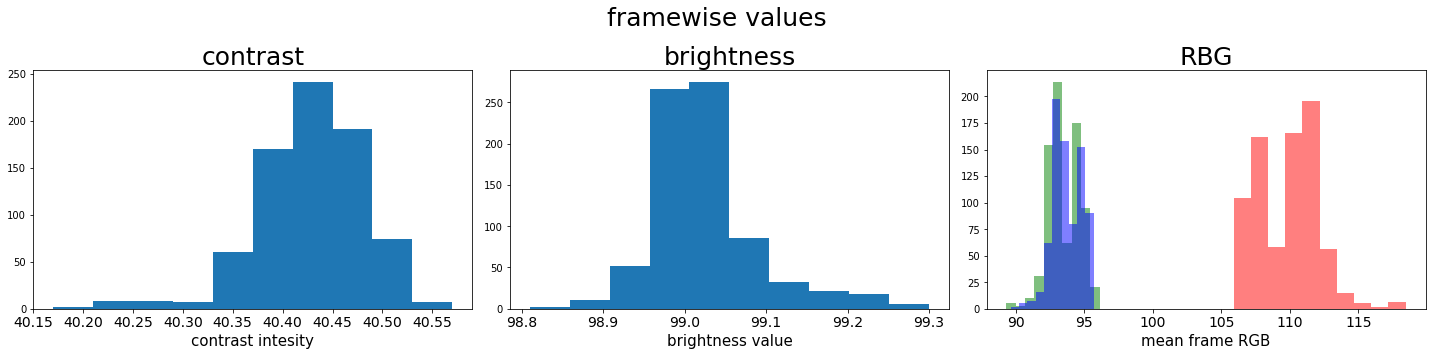

In [31]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.hist(all_contrast)
plt.title('contrast',fontsize=25)
plt.xlabel('contrast intesity',fontsize=15)
plt.xticks(fontsize=14)

plt.subplot(1,3,2)
plt.hist(all_brightness)
plt.title('brightness',fontsize=25)
plt.xlabel('brightness value',fontsize=15)
plt.xticks(fontsize=14)

plt.subplot(1,3,3)
plt.hist(all_rbg[:,0],color='r',alpha=.5)
plt.hist(all_rbg[:,1],color='g',alpha=.5)
plt.hist(all_rbg[:,2],color='b',alpha=.5)

plt.title('RBG',fontsize=25)
plt.xlabel('mean frame RGB',fontsize=15)
plt.xticks(fontsize=14)

plt.suptitle('framewise values',fontsize=25)

plt.tight_layout()

In [89]:
def return_frame2(img,enlarge=0):
    
    trained_data = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    #img = cv2.imread(image_fn)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cordinates = trained_data.detectMultiScale(gray_img)
    face_cordinates = face_cordinates + [-enlarge,-enlarge,enlarge*2,enlarge*2]
    
    return face_cordinates

In [90]:
def crop_frame_to_rect(image_fn,rect,debug=False):
    img = cv2.imread(image_fn)
    img2 = cv2.imread(image_fn)
    for (x, y, w, h) in rect:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), -2)
        
    img2[img!=0]=0

    if debug==False:
        return img2
    else:
        return img2,img

In [91]:
def crop_frame_to_rect2(img,rect,debug=False):
    img1 = img.copy()
    img2 = img.copy()
    for (x, y, w, h) in rect:
        cv2.rectangle(img1, (x, y), (x+w, y+h), (0, 0, 0), -2)
        
    img2[img1!=0]=0

    if debug==False:
        return img2
    else:
        return img2,img1

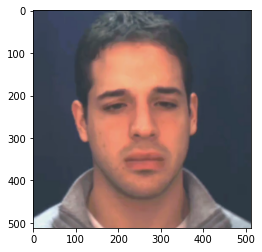

In [98]:
plt.imshow(img)

In [93]:
video_data = load_video(files[f])
img = video_data[0,:,:,:]
rect = return_frame2(img)

In [96]:
rect

array([[ 94, 100, 323, 323]])

In [99]:
im2.shape

(512, 512, 3)

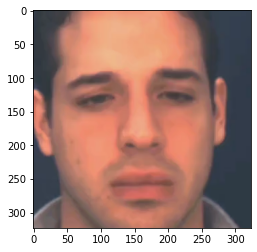

In [103]:
plt.imshow(img[94:94+323,100:100+323,:])

In [94]:
im2 = crop_frame_to_rect2(img,rect,debug=False)

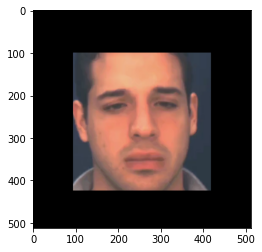

In [95]:
plt.imshow(im2)